# 1장. 시계열 예측 발전사

# 1장 코드는 책 본문에서 언급하지 않고 결과물만 보여줍니다.

## 시계열 예측 개요

### 종속 데이터의 문제점(The problem with dependent data)

#매 ipynb 파일 실행 시 구글 드라이브 연동(mounting)을 시행합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.interpolate import make_interp_spline

In [ ]:
# 약 30초 런타임 소요
df = pd.read_csv('/content/drive/MyDrive/Book7/data/spurious_correlations.csv')

In [ ]:
x_new = np.linspace(df['Year'].min(), df['Year'].max(), 300)
Nic_Cage_smooth = make_interp_spline(df['Year'],
                                     df['Number of films Nicolas Cage appeared in'],
                                     k=3,
                                     bc_type='natural')(x_new)
pool_drownings_smooth = make_interp_spline(df['Year'],
                                           df['Number people who drowned by falling into a swimming-pool'],
                                           k=3,
                                           bc_type='natural')(x_new)

df2 = pd.DataFrame({'Year': x_new,
                    'Number of films Nicolas Cage appeared in': Nic_Cage_smooth,
                    'Number people who drowned by falling into a swimming-pool': pool_drownings_smooth})

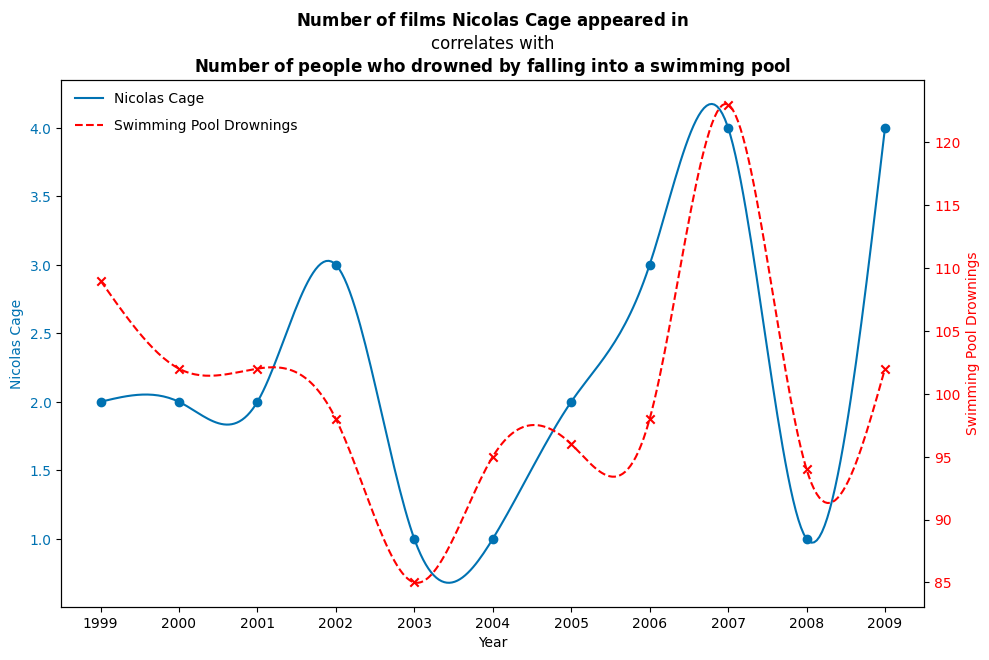

In [ ]:
### 원서 코드에 역자 수정 코드 추가
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color = '#0072B2'
ax1.set_xlabel('Year')
ax1.set_ylabel('Nicolas Cage', color=color)
ax1.plot(df2['Year'], df2['Number of films Nicolas Cage appeared in'], color=color, ls='-', label='Nicolas Cage')
ax1.scatter(df['Year'], df['Number of films Nicolas Cage appeared in'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=(0.01, .94), frameon=False)

ax2 = ax1.twinx()  # x축 공유하는 두 번째 y축 생성

color = 'r'
ax2.set_ylabel('Swimming Pool Drownings', color=color)
ax2.plot(df2['Year'], df2['Number people who drowned by falling into a swimming-pool'], color=color, ls='--', label='Swimming Pool Drownings')
ax2.scatter(df['Year'], df['Number people who drowned by falling into a swimming-pool'], color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc=(0.01, .89), frameon=False)

fig.tight_layout()  # 여백 조정

# 제목 수정: LaTeX 스타일 적용
plt.title(r'$\mathbf{Number\ of\ films\ Nicolas\ Cage\ appeared\ in}$' +
          '\ncorrelates with\n' +
          r'$\mathbf{Number\ of\ people\ who\ drowned\ by\ falling\ into\ a\ swimming\ pool}$')

plt.xticks(ticks=df['Year'].tolist(), labels=df['Year'].tolist())

plt.show()


### 이동평균과 지수평활법(Moving average and exponential smoothing)

In [ ]:
### 원서 코드에 역자 수정 코드 추가
import pandas as pd

# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/Book7/data/instagram_natgeo.csv')

# 날짜 변환
data['created_time'] = pd.to_datetime(data['Date'])

# 2015년 데이터 필터링
df = data[(data['created_time'] >= '2015-01-01') & (data['created_time'] < '2016-01-01')][['created_time', 'Average Likes Per Photo']]

# 그룹화 및 평균 계산 (created_time을 날짜별 그룹화 후 컬럼명 변경)
df = df.groupby(df['created_time'].dt.date)['Average Likes Per Photo'].mean().reset_index()
df = df.rename(columns={'created_time': 'date'})  # created_time → date로 변경
df = df.rename(columns={'date': 'created_time'})  # 역자의 재 변경 created_time → date로 변경

# likes 컬럼 추가 (단위 변환)
df['likes'] = df['Average Likes Per Photo'] / 1000


In [ ]:
df.head(2)

,created_time,Average Likes Per Photo,likes
0,2015-01-01,243457.7222,243.457722
1,2015-01-02,248047.3333,248.047333


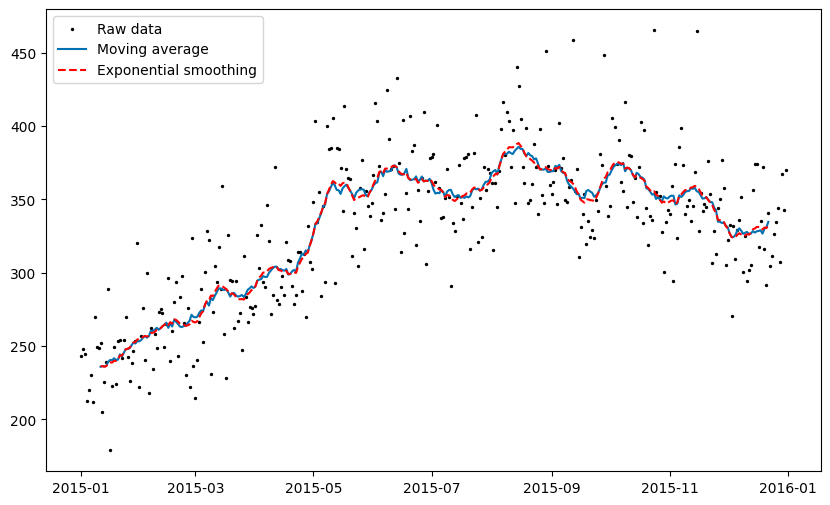

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['created_time'], df['likes'], label='Raw data', c='k', s=2)
plt.plot(df['created_time'],
         df['likes'].rolling(window=20, center=True).mean(),
         label='Moving average',
         ls='-',
         c='#0072B2')
plt.plot(df['created_time'],
         df['likes'].rolling(window=20, center=True, win_type='exponential').mean(tau=10),
         label='Exponential smoothing',
         ls='--',
         c='r')
plt.legend()
plt.show()

### ARCH/GARCH

In [ ]:
x = np.arange(0, 100, .5)
y1 = [25 + .5 * val + 7 * random.random() for val in x]
y2 = [.5 * val + 3 * (random.random() - .5) * val / 7 for val in x]

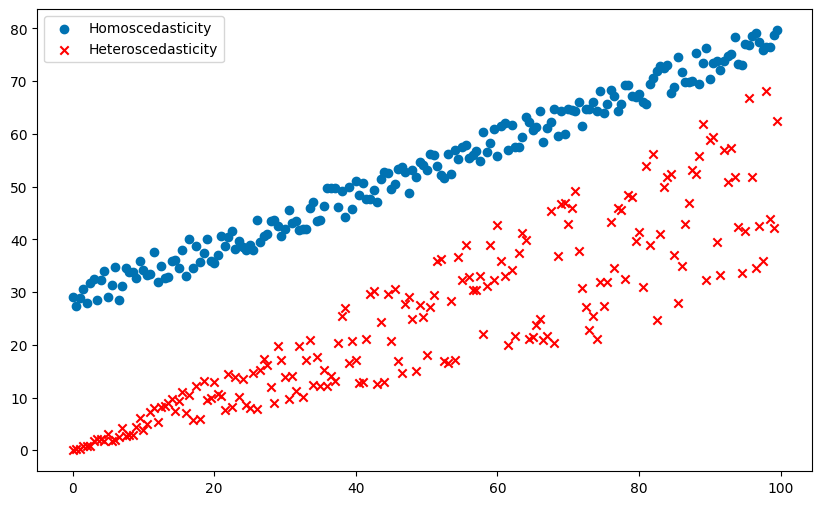

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y1, label='Homoscedasticity', marker='o', c='#0072B2')
plt.scatter(x, y2, label='Heteroscedasticity', marker='x', c='r')
plt.legend()
plt.show()

### Prophet

In [ ]:
x = pd.date_range('2000-01-01', '2003-12-31', freq='H')
y0 = [1000 + .025 * val for val in range(len(x))]  # create trend curve
y1 = [50 * np.sin(idx * (360 / (365.25 * 24)) * (np.pi / 180)) for idx in range(len(y0))]  # add annual sinusoidal variation
y2 = [(25 * np.sin(((idx / 7) - 17) * (360 / 24) * (np.pi / 180))) +
      (10 * np.sin(((idx / 7) - 5) * (360 / 12) * (np.pi / 180))) +
      (25 * np.sin(((idx / 7) - 12) * (360 / 12) * (np.pi / 180))) +
      (15 * np.sin(((idx / 7) - 20) * (360 / 12) * (np.pi / 180)))
      for idx in range(len(x))]  # add weekly variation
y3 = [20 * np.sin((idx - 6) * (360 / 24) * (np.pi / 180)) for idx in range(len(y2))]  # add daily sinusoidal variation

# Create additive curves
z0 = y0
z1 = [y0[idx] + y1[idx] for idx in range(len(x))]
z2 = [y0[idx] + y1[idx] + y2[idx] for idx in range(len(x))]
z3 = [y0[idx] + y1[idx] + y2[idx] + y3[idx] for idx in range(len(x))]

/tmp/ipython-input-16-495911337.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x = pd.date_range('2000-01-01', '2003-12-31', freq='H')


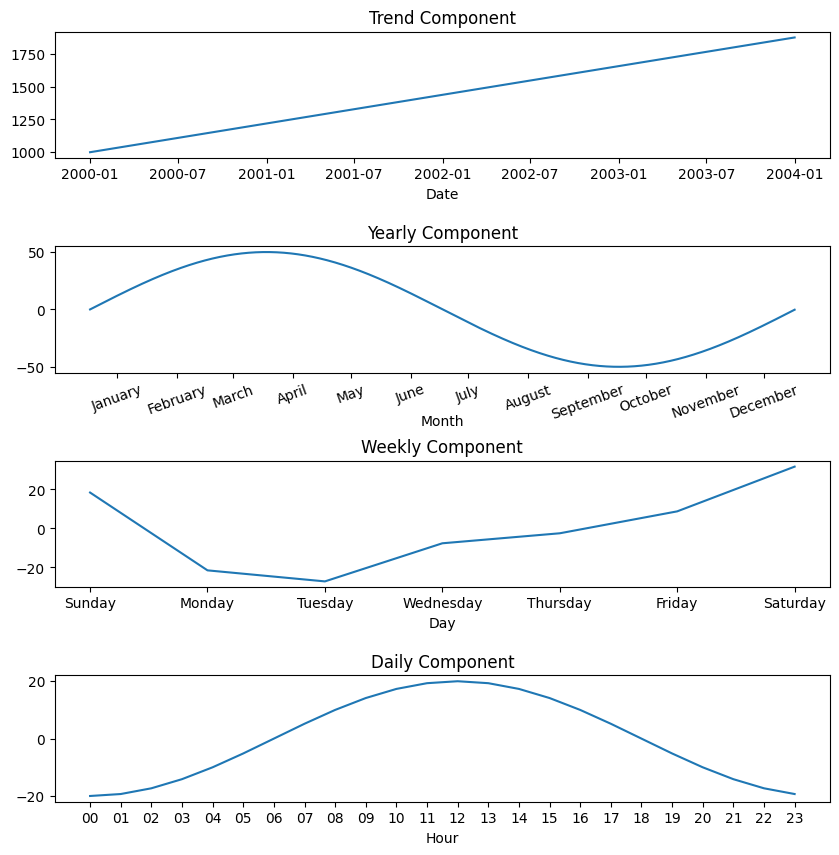

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=.7)

ax[0].set_title('Trend Component')
ax[0].plot(x, y0)
ax[0].set_xlabel('Date')
# ax[0].set_ylabel('Contribution to Sales')

ax[1].set_title('Yearly Component')
ax[1].plot(x[:24 * 365], y1[:24 * 365])
ax[1].set_xticks([ts for ts in x[:24 * 365] if ts.hour == 0 and ts.day == 15])
ax[1].set_xticklabels([ts.month_name() for ts in x[:24 * 365] if ts.hour == 0 and ts.day == 15], rotation=20)
ax[1].set_xlabel('Month', labelpad=-5)
# ax[1].set_ylabel('Contribution to Sales')

ax[2].set_title('Weekly Component')
ax[2].plot([ts.day_name() for ts in x[24: 24 * 8] if ts.hour == 12], [y2[idx] for idx in range(len(x[24: 24 * 8])) if x[idx].hour == 23])
ax[2].set_xlabel('Day')
# ax[2].set_ylabel('Contribution to Sales')

ax[3].set_title('Daily Component')
ax[3].plot(x[:24].strftime('%#H'), y3[:24])
ax[3].set_xlabel('Hour')
# ax[3].set_ylabel('Contribution to Sales')

plt.show()

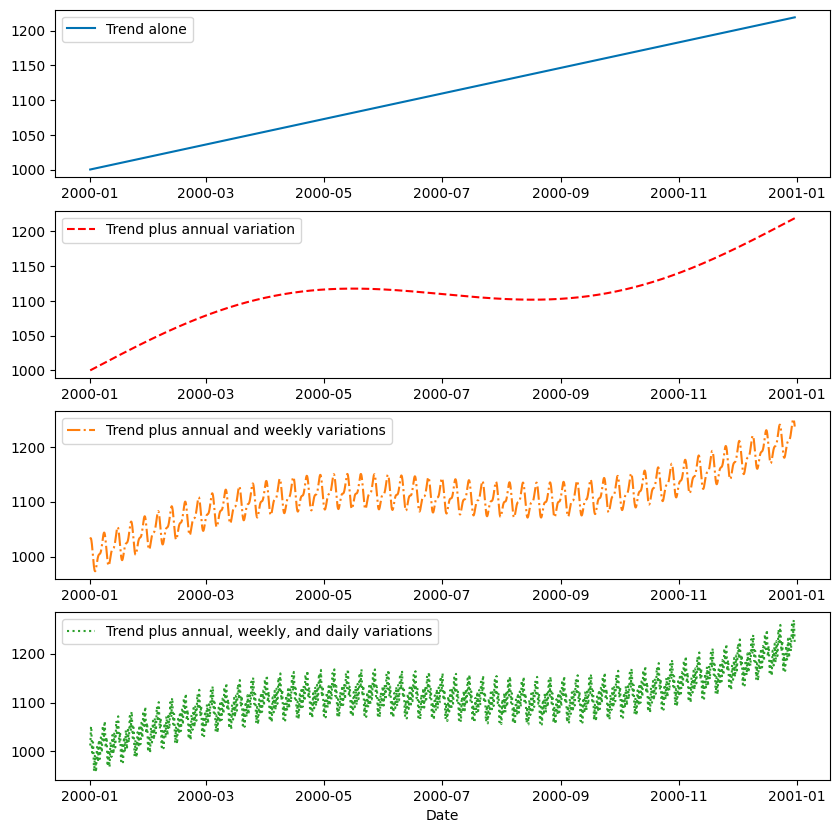

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

ax[0].plot(x[:8760], z0[:8760], label='Trend alone', c='#0072B2', ls='-')
ax[0].legend()

ax[1].plot(x[:8760], z1[:8760], label='Trend plus annual variation', c='r', ls='--')
ax[1].legend()

ax[2].plot(x[:8760], z2[:8760], label='Trend plus annual and weekly variations', c='tab:orange', ls='-.')
ax[2].legend()

ax[3].plot(x[:8760], z3[:8760], label='Trend plus annual, weekly, and daily variations', c='tab:green', ls=':')
ax[3].legend()
ax[3].set_xlabel('Date')

plt.show()